<a href="https://colab.research.google.com/github/bhatnagaraashish/AML_Transaction_Monitoring_Rules_Engine/blob/main/AML_Transaction_Monitoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AML Transaction Monitoring - Mock Dataset Creation**

# **1️⃣ Imports & Setup**

**1. Business & Regulatory Context**

Why this notebook exists

Financial institutions are required under FATF, EU AMLD, and CBI expectations to:

* Maintain accurate customer risk profiles

* Monitor transactions in line with customer risk

* Evidence that monitoring scenarios are calibrated to real behaviour

In production environments, this data comes from core banking and payment systems. For this project, synthetic but realistic datasets are created to simulate those inputs.

In [11]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

np.random.seed(42)
random.seed(42)


## **2️⃣ Create Customer Master Dataset (customers.csv)**
Define reference data

**Why these customer attributes were chosen**
*Attribute	                     Rationale*
customer_type	     Monitoring thresholds differ for individuals vs businesses
country	           Jurisdictional risk is a key AML risk driver
risk_rating	       Core input for risk-based monitoring
pep_flag	         PEPs require enhanced scrutiny
onboarding_date	   Enables lifecycle and review logic later
**Why the distributions matter**

* Majority Low/Medium risk reflects real portfolios

* Small High-risk and PEP population mirrors real AML exposure

* Prevents “alert inflation” and unrealistic models

**👉 Decision supported:**
Whether monitoring rules appropriately scale with customer risk.

In [12]:
customer_count = 300

countries = ["Ireland", "UK", "Germany", "France", "UAE", "Turkey", "Nigeria", "Russia"]
high_risk_countries = ["Nigeria", "Russia"]

customer_types = ["Individual", "Business"]
risk_ratings = ["Low", "Medium", "High"]


Generate customers

In [13]:
customers = []

for i in range(1, customer_count + 1):
    customer_id = f"CUST{i:04d}"

    customer_type = random.choices(
        customer_types, weights=[0.75, 0.25]
    )[0]

    country = random.choice(countries)

    risk_rating = random.choices(
        risk_ratings, weights=[0.6, 0.3, 0.1]
    )[0]

    pep_flag = "Y" if random.random() < 0.08 else "N"

    onboarding_date = datetime.today() - timedelta(
        days=random.randint(30, 1200)
    )

    customers.append([
        customer_id,
        customer_type,
        country,
        risk_rating,
        pep_flag,
        onboarding_date.date()
    ])

customers_df = pd.DataFrame(
    customers,
    columns=[
        "customer_id",
        "customer_type",
        "country",
        "risk_rating",
        "pep_flag",
        "onboarding_date"
    ]
)

customers_df.head()


,customer_id,customer_type,country,risk_rating,pep_flag,onboarding_date
0,CUST0001,Individual,Ireland,Medium,N,2025-02-11
1,CUST0002,Individual,UK,Low,Y,2025-05-16
2,CUST0003,Individual,Ireland,Low,N,2022-11-03
3,CUST0004,Individual,Russia,Low,N,2025-11-10
4,CUST0005,Business,Germany,Medium,N,2025-01-09


Save file

In [14]:
from pathlib import Path

Path('../data').mkdir(parents=True, exist_ok=True)

customers_df.to_csv("../data/customers.csv", index=False)

# **3️⃣ Create Transaction Dataset** bold text (transactions.csv)

Transaction parameters

** Transaction Dataset – Design Rationale**

**Why these transaction features were included**

**Feature **	                **Why it matters**

amount	                     Primary trigger for threshold-based rules
transaction_date	           Enables velocity & structuring analysis
channel	                     Cash & crypto carry higher inherent risk
country	                     Cross-border & high-risk country exposure
transaction_type	           Credit vs debit risk differs

**Why transaction amounts are risk-weighted**

Higher-risk customers generate higher average transaction values to simulate:

* More complex financial behaviour
* Greater potential ML/TF exposure

# **Why near-threshold transactions were injected**

A small percentage of transactions are deliberately placed just below reporting thresholds to simulate:

* Structuring behaviour

* Threshold evasion risks

**👉 Decision supported:**
Whether monitoring rules can detect non-obvious suspicious behaviour.

In [15]:
transaction_count = 5000

channels = ["Online", "Cash", "Crypto"]
transaction_types = ["Credit", "Debit"]
currencies = ["EUR", "USD"]


Generate transactions

In [16]:
transactions = []

for i in range(1, transaction_count + 1):
    transaction_id = f"TXN{i:06d}"

    customer = customers_df.sample(1).iloc[0]

    transaction_date = datetime.today() - timedelta(
        days=random.randint(0, 180),
        hours=random.randint(0, 23)
    )

    # Amount logic (realistic AML behaviour)
    if customer["risk_rating"] == "High":
        amount = round(np.random.exponential(scale=6000), 2)
    else:
        amount = round(np.random.exponential(scale=2500), 2)

    # Force some near-threshold behaviour
    if random.random() < 0.05:
        amount = random.uniform(9500, 9999)

    transaction_country = random.choice(countries)

    channel = random.choices(
        channels, weights=[0.6, 0.25, 0.15]
    )[0]

    transaction_type = random.choice(transaction_types)

    currency = random.choice(currencies)

    transactions.append([
        transaction_id,
        customer["customer_id"],
        transaction_date,
        amount,
        currency,
        transaction_country,
        channel,
        transaction_type
    ])

transactions_df = pd.DataFrame(
    transactions,
    columns=[
        "transaction_id",
        "customer_id",
        "transaction_date",
        "amount",
        "currency",
        "country",
        "channel",
        "transaction_type"
    ]
)

transactions_df.head()


,transaction_id,customer_id,transaction_date,amount,currency,country,channel,transaction_type
0,TXN000001,CUST0204,2025-10-05 22:07:55.193699,2493.34,USD,Nigeria,Online,Debit
1,TXN000002,CUST0244,2025-08-31 11:07:55.194269,10671.93,USD,Turkey,Cash,Debit
2,TXN000003,CUST0221,2025-07-13 11:07:55.195417,1100.52,EUR,Nigeria,Online,Credit
3,TXN000004,CUST0280,2025-11-16 17:07:55.196203,1869.42,EUR,Russia,Online,Credit
4,TXN000005,CUST0121,2025-07-11 01:07:55.196609,655.26,USD,Ireland,Cash,Debit


# **4️⃣ Basic Data Quality Checks (Important for QA Signalling)**

Basic data validation checks were performed to ensure:

* No missing critical fields

* Referential integrity between customers and transactions

* Suitability of data for downstream monitoring logic

This mirrors first-line QA controls typically expected in regulated environments.

**👉 Decision supported:**
Whether the dataset is fit for compliance monitoring and reporting.



In [17]:
print("Customers:", customers_df.shape)
print("Transactions:", transactions_df.shape)

print("\nMissing values:")
print(transactions_df.isnull().sum())


Customers: (300, 6)
Transactions: (5000, 8)

Missing values:
transaction_id      0
customer_id         0
transaction_date    0
amount              0
currency            0
country             0
channel             0
transaction_type    0
dtype: int64


Save Transaction File

In [18]:
transactions_df.to_csv("../data/transactions.csv", index=False)

Quick Sanity Visuals (Optional but Good)

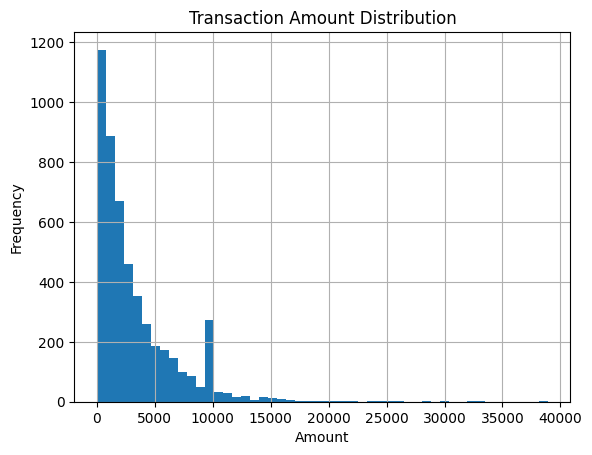

In [19]:
import matplotlib.pyplot as plt

transactions_df["amount"].hist(bins=50)
plt.title("Transaction Amount Distribution")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()


# **Summary of Key Findings**

**Customer portfolio reflects a realistic AML risk mix, avoiding artificial bias**

**Transaction data contains:**

* Normal customer behaviour

* Edge cases relevant for AML detection

**Embedded risk patterns allow meaningful rule testing in later stages**

**Dataset is suitable for:**

* Transaction monitoring

* Risk scoring

* Compliance MI

# **Limitations & Assumptions**

* Data is synthetic and not linked to real customers

* Sanctions screening and adverse media are out of scope

* Currency conversion risk not modelled at this stage